In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


In [2]:
delhi_neigh="Adarsh Nagar,Ashok Vihar,Begum Pur,Karala,Model Town,Narela,Pitam Pura,Rohini Sub City,Shalimar Bagh,Civil Lines,Gulabi Bagh,Kamla Nagar,Kashmiri Gate,Kotwali,Mori Gate; Delhi,Sadar Bazaar,Sarai Rohilla,Shakti Nagar,Shastri Nagar,Tis Hazari,Timarpur,Wazirabad,Dilshad Garden,Naveen Shahdara,New Usmanpur,Shahdara,Shastri Park,Yamuna Vihar,Chandni Chowk,Daryaganj,Jhandewalan,Karol Bagh,Kishanganj,Paharganj,Rajender Nagar,New Delhi,Barakhamba Road,Chanakyapuri,Connaught Place,Gole Market,INA Colony,Laxmibai Nagar,Pragati Maidan,East Vinod Nagar,Jhilmil Colony,Laxmi Nagar,Mayur Vihar,Pandav Nagar,Preet Vihar,Anand Vihar,Vasundhara Enclave,Vishwas Nagar,Vivek Vihar,Alaknanda,Chittaranjan Park,Defence Colony,East of Kailash,Govindpuri,Greater Kailash,Green Park,Gulmohar Park,Hauz Khas,Hauz Khas VillageJangpura,Jor Bagh,Kalkaji,Khanpur,Lajpat Nagar,Lodi Colony,Malviya Nagar,Mehrauli,Neeti Bagh,Nehru Place,Netaji Nagar,New Friends Colony,Nizamuddin West,Okhla,Safdarjung Enclave,Sainik Farm,Saket,Sangam Vihar,Sarita Vihar,Sarojini Nagar,Sarvodaya Enclave,Siri Fort,South Extension,Sriniwaspuri,Sundar Nagar,Tughlaqabad,Badarpur,Dabri,Dwarka Sub City,Delhi Cantonment,Dhaula Kuan,Inderpuri,Mahipalpur,Moti Bagh,Munirka,Najafgarh,Naraina,Palam,Rama Krishna Puram,Sagar Pur,Vasant Kunj,Vasant Vihar,Ashok Nagar,Bali Nagar,Fateh Nagar,Kirti Nagar,Moti Nagar,Paschim Vihar,Patel Nagar,Punjabi Bagh,Rajouri Garden,Tihar Village,Tilak Nagar,Vikas Nagar,Vikaspuri"
place=[substring.strip() for substring in delhi_neigh.split(',')]
st=", Delhi"
place=[s + st for s in place]


In [4]:
latitude=[]
longitude=[]
geolocator = Nominatim(user_agent="Coursera")
for address in place:
  location = geolocator.geocode(address)
  if(location==None):
    place.remove(address)
    continue
  else:
    latitude.append(location.latitude)
    longitude.append(location.longitude)

print(len(place),len(latitude),len(longitude))

111 111 111


In [5]:
dict_={"Neighborhood":place,"Latitude":latitude,"Longitude":longitude}
delhi_neighborhood=pd.DataFrame(dict_)
delhi_neighborhood.head(10)

,Neighborhood,Latitude,Longitude
0,"Adarsh Nagar, Delhi",28.614193,77.071541
1,"Ashok Vihar, Delhi",28.699453,77.184826
2,"Karala, Delhi",28.735140,77.032511
3,"Model Town, Delhi",28.702714,77.193991
4,"Narela, Delhi",28.842610,77.091835
5,"Pitam Pura, Delhi",28.703268,77.132250
6,"Shalimar Bagh, Delhi",28.717453,77.150867
7,"Civil Lines, Delhi",28.676851,77.225030
8,"Gulabi Bagh, Delhi",28.669649,77.194726
9,"Kamla Nagar, Delhi",28.680344,77.202129


In [6]:
key="86150eeacd6e760db3f518f5ad8251b3"
cols=["id","name","locality","cuisines","votes"]
df=pd.DataFrame(columns=cols)

In [7]:
for lat,lon in zip(delhi_neighborhood['Latitude'],delhi_neighborhood['Longitude']):
  base="https://developers.zomato.com/api/v2.1/geocode?lat={}&lon={}".format(lat,lon)
  header={"Accept": "application/json", "user-key": key}
  res=requests.get(base,headers=header)
  result=res.content.decode("utf-8")
  result=json.loads(result)
  tt=result["nearby_restaurants"]
  df1=[]
  for i in range(len(tt)):
    test=tt[i]
    df1.append([test["restaurant"]["id"],
                test["restaurant"]["name"],
                test["restaurant"]["location"]["locality"],
                test["restaurant"]["cuisines"],
                test["restaurant"]["user_rating"]["votes"]]
              )
    df=df.append(pd.DataFrame(df1,columns=cols))

df=df.drop_duplicates(subset=None,keep='first')
df.reset_index(inplace=True)
df.id=df.id.astype('int64')
df.votes=df.votes.astype('int64')
df.dtypes

index        int64
id           int64
name        object
locality    object
cuisines    object
votes        int64
dtype: object

In [8]:
df.head(10)

,index,id,name,locality,cuisines,votes
0,0,18810973,Delhi Darbar Biryani Point,Uttam Nagar,"Biryani, Mughlai",25873
1,1,18358654,Scoops,Uttam Nagar,"Beverages, Fast Food, Desserts",13699
2,2,301907,Sargam Sweets,Uttam Nagar,"Mithai, Chinese, South Indian, North Indian, B...",13144
3,3,5469,Kali Ghata,Uttam Nagar,"North Indian, South Indian, Chinese, Fast Food...",1418
4,4,18530863,Anand Vaishno Dhaba,Uttam Nagar,North Indian,7503
5,5,5470,Lala Da Shudh Vaishno Dhaba,Uttam Nagar,North Indian,17801
6,6,18637444,Shakil Chicken Corner,Uttam Nagar,North Indian,11794
7,7,18698057,Rolls Mania,Uttam Nagar,"Rolls, Fast Food, Beverages",7490
8,8,312073,Domino's Pizza,Uttam Nagar,"Pizza, Fast Food",7138
9,0,307406,Pandit Ji Parantha Hut,Ashok Vihar Phase 2,North Indian,55180


# Dividing the Votes
The following code is written to divide the votes evenly into cuisines

In [9]:
a=df['cuisines'].str.split(',')
b=[len(c) for c in a]
a=pd.Series(b)
df=df.assign(cuisines=df['cuisines'].str.split(',')).explode('cuisines')
df.cuisines=df.cuisines.str.lstrip()
df.votes=df.votes/a
df.votes=df.votes.astype('int64')
df.head()

,index,id,name,locality,cuisines,votes
0,0,18810973,Delhi Darbar Biryani Point,Uttam Nagar,Biryani,12936
0,0,18810973,Delhi Darbar Biryani Point,Uttam Nagar,Mughlai,12936
1,1,18358654,Scoops,Uttam Nagar,Beverages,4566
1,1,18358654,Scoops,Uttam Nagar,Fast Food,4566
1,1,18358654,Scoops,Uttam Nagar,Desserts,4566


In [10]:
print(df.cuisines.nunique())
print(df.locality.nunique())

67
158


In [11]:
df.insert(3,"No Of Res",1)
df.head()

,index,id,name,No Of Res,locality,cuisines,votes
0,0,18810973,Delhi Darbar Biryani Point,1,Uttam Nagar,Biryani,12936
0,0,18810973,Delhi Darbar Biryani Point,1,Uttam Nagar,Mughlai,12936
1,1,18358654,Scoops,1,Uttam Nagar,Beverages,4566
1,1,18358654,Scoops,1,Uttam Nagar,Fast Food,4566
1,1,18358654,Scoops,1,Uttam Nagar,Desserts,4566


In [12]:
cols=["locality","cuisines","No Of Res","votes"]
df1=df[cols]
df1.head()

,locality,cuisines,No Of Res,votes
0,Uttam Nagar,Biryani,1,12936
0,Uttam Nagar,Mughlai,1,12936
1,Uttam Nagar,Beverages,1,4566
1,Uttam Nagar,Fast Food,1,4566
1,Uttam Nagar,Desserts,1,4566


In [13]:
cols=["locality","cuisines"]
df1=df1.groupby(cols).sum()
df1.head()

No Of Res  votes
locality cuisines                      
Adchini  Chettinad             1    178
         French                1    178
         South Indian          1    178
         Tamil                 1    178
Aerocity Asian                 1    459

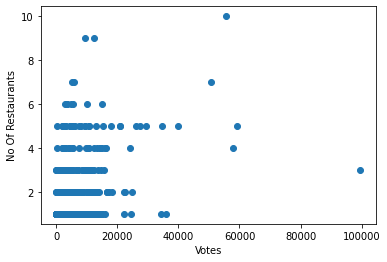

In [14]:
plt.scatter(x=df1["votes"],y=df1["No Of Res"])
plt.xlabel("Votes")
plt.ylabel("No Of Restaurants")
plt.show()

#Code to find the best value of K

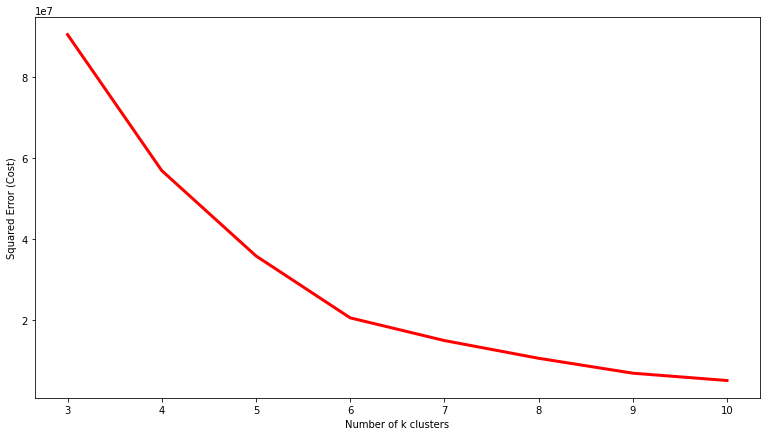

In [15]:
error_cost=[]
cols=["No Of Res","votes"]
for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df1[cols])

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

## As the best value came out to be 6, We'll be dividing the above data frame into 6 clusters

In [16]:
# set number of clusters
kclusters = 6
cols=["No Of Res","votes"]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df1[cols])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

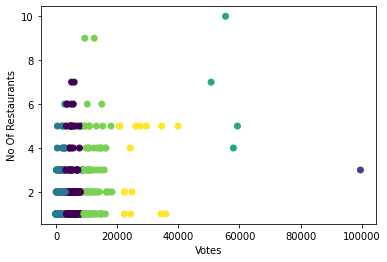

In [17]:
plt.scatter(x=df1["votes"],y=df1["No Of Res"],c=kmeans.labels_)
plt.xlabel("Votes")
plt.ylabel("No Of Restaurants")
plt.show()

In [18]:
df1["Cluster Label"]=kmeans.labels_

In [22]:
df1.loc[df1['Cluster Label'] == 1]

,,No Of Res,votes,Cluster Label
locality,cuisines,,,
Karkardooma,North Indian,3,99563,1


In [31]:
df1.loc[df1['Cluster Label'] ==3]

,,No Of Res,votes,Cluster Label
locality,cuisines,,,
Ashok Vihar Phase 2,North Indian,5,59334,3
IP Extension,North Indian,4,58012,3
Paschim Vihar,North Indian,7,50717,3
Shahdara,North Indian,10,55461,3
